In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Vamos a definir una funcion (Mergeador_data) que tome el dataset de las observaciones y el dataset de DAM_GEODATA, haga un merge y se quede con los features de los que luego analizaremos la varianza

In [129]:
#Traemos los data frames

PVR_observaciones_18 = pd.read_csv('/Datasets/PVR_observaciones_promedio_cutoff18.csv')
PVR_observaciones_375 = pd.read_csv('/Datasets/PVR_observaciones_promedio_cutoff375.csv')
PVR_observaciones = pd.read_csv('/Datasets/PVR_Obs_Cutoff.csv', delimiter= ';')
PVR_DAM_geodata = pd.read_csv('/Datasets/PVR_DAM_geodata(1).csv', delimiter= ';')

def Mergeador_data (data1, data2):
    
    #Guardamos las variables en forma global, para llamarlas en cualquier momento
    global PVR_train_test, DAM_to_predict, PVR_train_test_copy
    
    #La funcion elimina los puntos del tipo intersección, Además guarda las intersecciones para luego hacer predicciones
    DAM_to_predict = data1[data1['punto_tipo'] == 'Intersercción']
    PVR_geodata = data1.drop(data1[data1['punto_tipo'] == 'Intersercción'].index)
    
    PVR_train_test = pd.merge(data2, data1 , how="left", on=["ID"]) 
    
    #Una vez que tenemos el PVR_train_test final, vamos a eliminar sus nulls
    PVR_train_test.dropna(axis=0, inplace= True)
    
    #Dejamos los features de ID, index, x, y, punto_tipo solo para las predicciones
    PVR_train_test_copy = PVR_train_test.copy()
    PVR_train_test.drop(['ID', 'index','x','y', 'punto_tipo'], axis=1, inplace= True)  
    
    #Hacemos dummies
    PVR_train_test = pd.get_dummies(PVR_train_test, drop_first=True)

In [131]:
#Invocamos al mergeador
Mergeador_data(PVR_DAM_geodata, PVR_observaciones_375)

In [132]:
PVR_train_test

,valoracion,poblacion,hogares,desocupado,0-14,65_mas,inicial,primario,egb,secundario,...,NoLee_ni_e,hacinamiento,sin_agua,sin_cloaca,densidad_comercial,microzonificacion_Comercial,microzonificacion_Residencial suburbano,microzonificacion_Residencial urbano,macrozonificacion_Interfaz,macrozonificacion_Urbano
0,0.0,848.0,259.0,39.0,190.0,97.0,35.0,124.0,80.0,180.0,...,40.0,1.0,0.0,23.0,0.0,0,0,1,0,1
1,1.0,620.0,215.0,17.0,101.0,103.0,16.0,79.0,42.0,156.0,...,22.0,1.0,0.0,0.0,7.0,0,0,1,0,1
2,1.0,519.0,245.0,9.0,65.0,132.0,11.0,73.0,12.0,119.0,...,14.0,0.0,0.0,0.0,5.0,1,0,0,0,0
3,1.0,519.0,245.0,9.0,65.0,132.0,11.0,73.0,12.0,119.0,...,14.0,0.0,0.0,0.0,5.0,1,0,0,0,0
4,1.0,664.0,268.0,21.0,104.0,120.0,16.0,103.0,12.0,154.0,...,18.0,2.0,2.0,0.0,2.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,1.0,876.0,287.0,39.0,157.0,125.0,23.0,229.0,59.0,261.0,...,35.0,3.0,0.0,1.0,9.0,0,0,1,0,1
75,1.0,528.0,188.0,11.0,87.0,102.0,16.0,40.0,24.0,82.0,...,16.0,0.0,0.0,0.0,10.0,0,0,1,0,1
76,0.0,1190.0,351.0,23.0,208.0,113.0,43.0,76.0,103.0,141.0,...,44.0,0.0,66.0,3.0,2.0,0,1,0,1,0
77,1.0,784.0,305.0,27.0,106.0,122.0,18.0,116.0,26.0,194.0,...,23.0,1.0,5.0,0.0,11.0,0,0,1,0,1


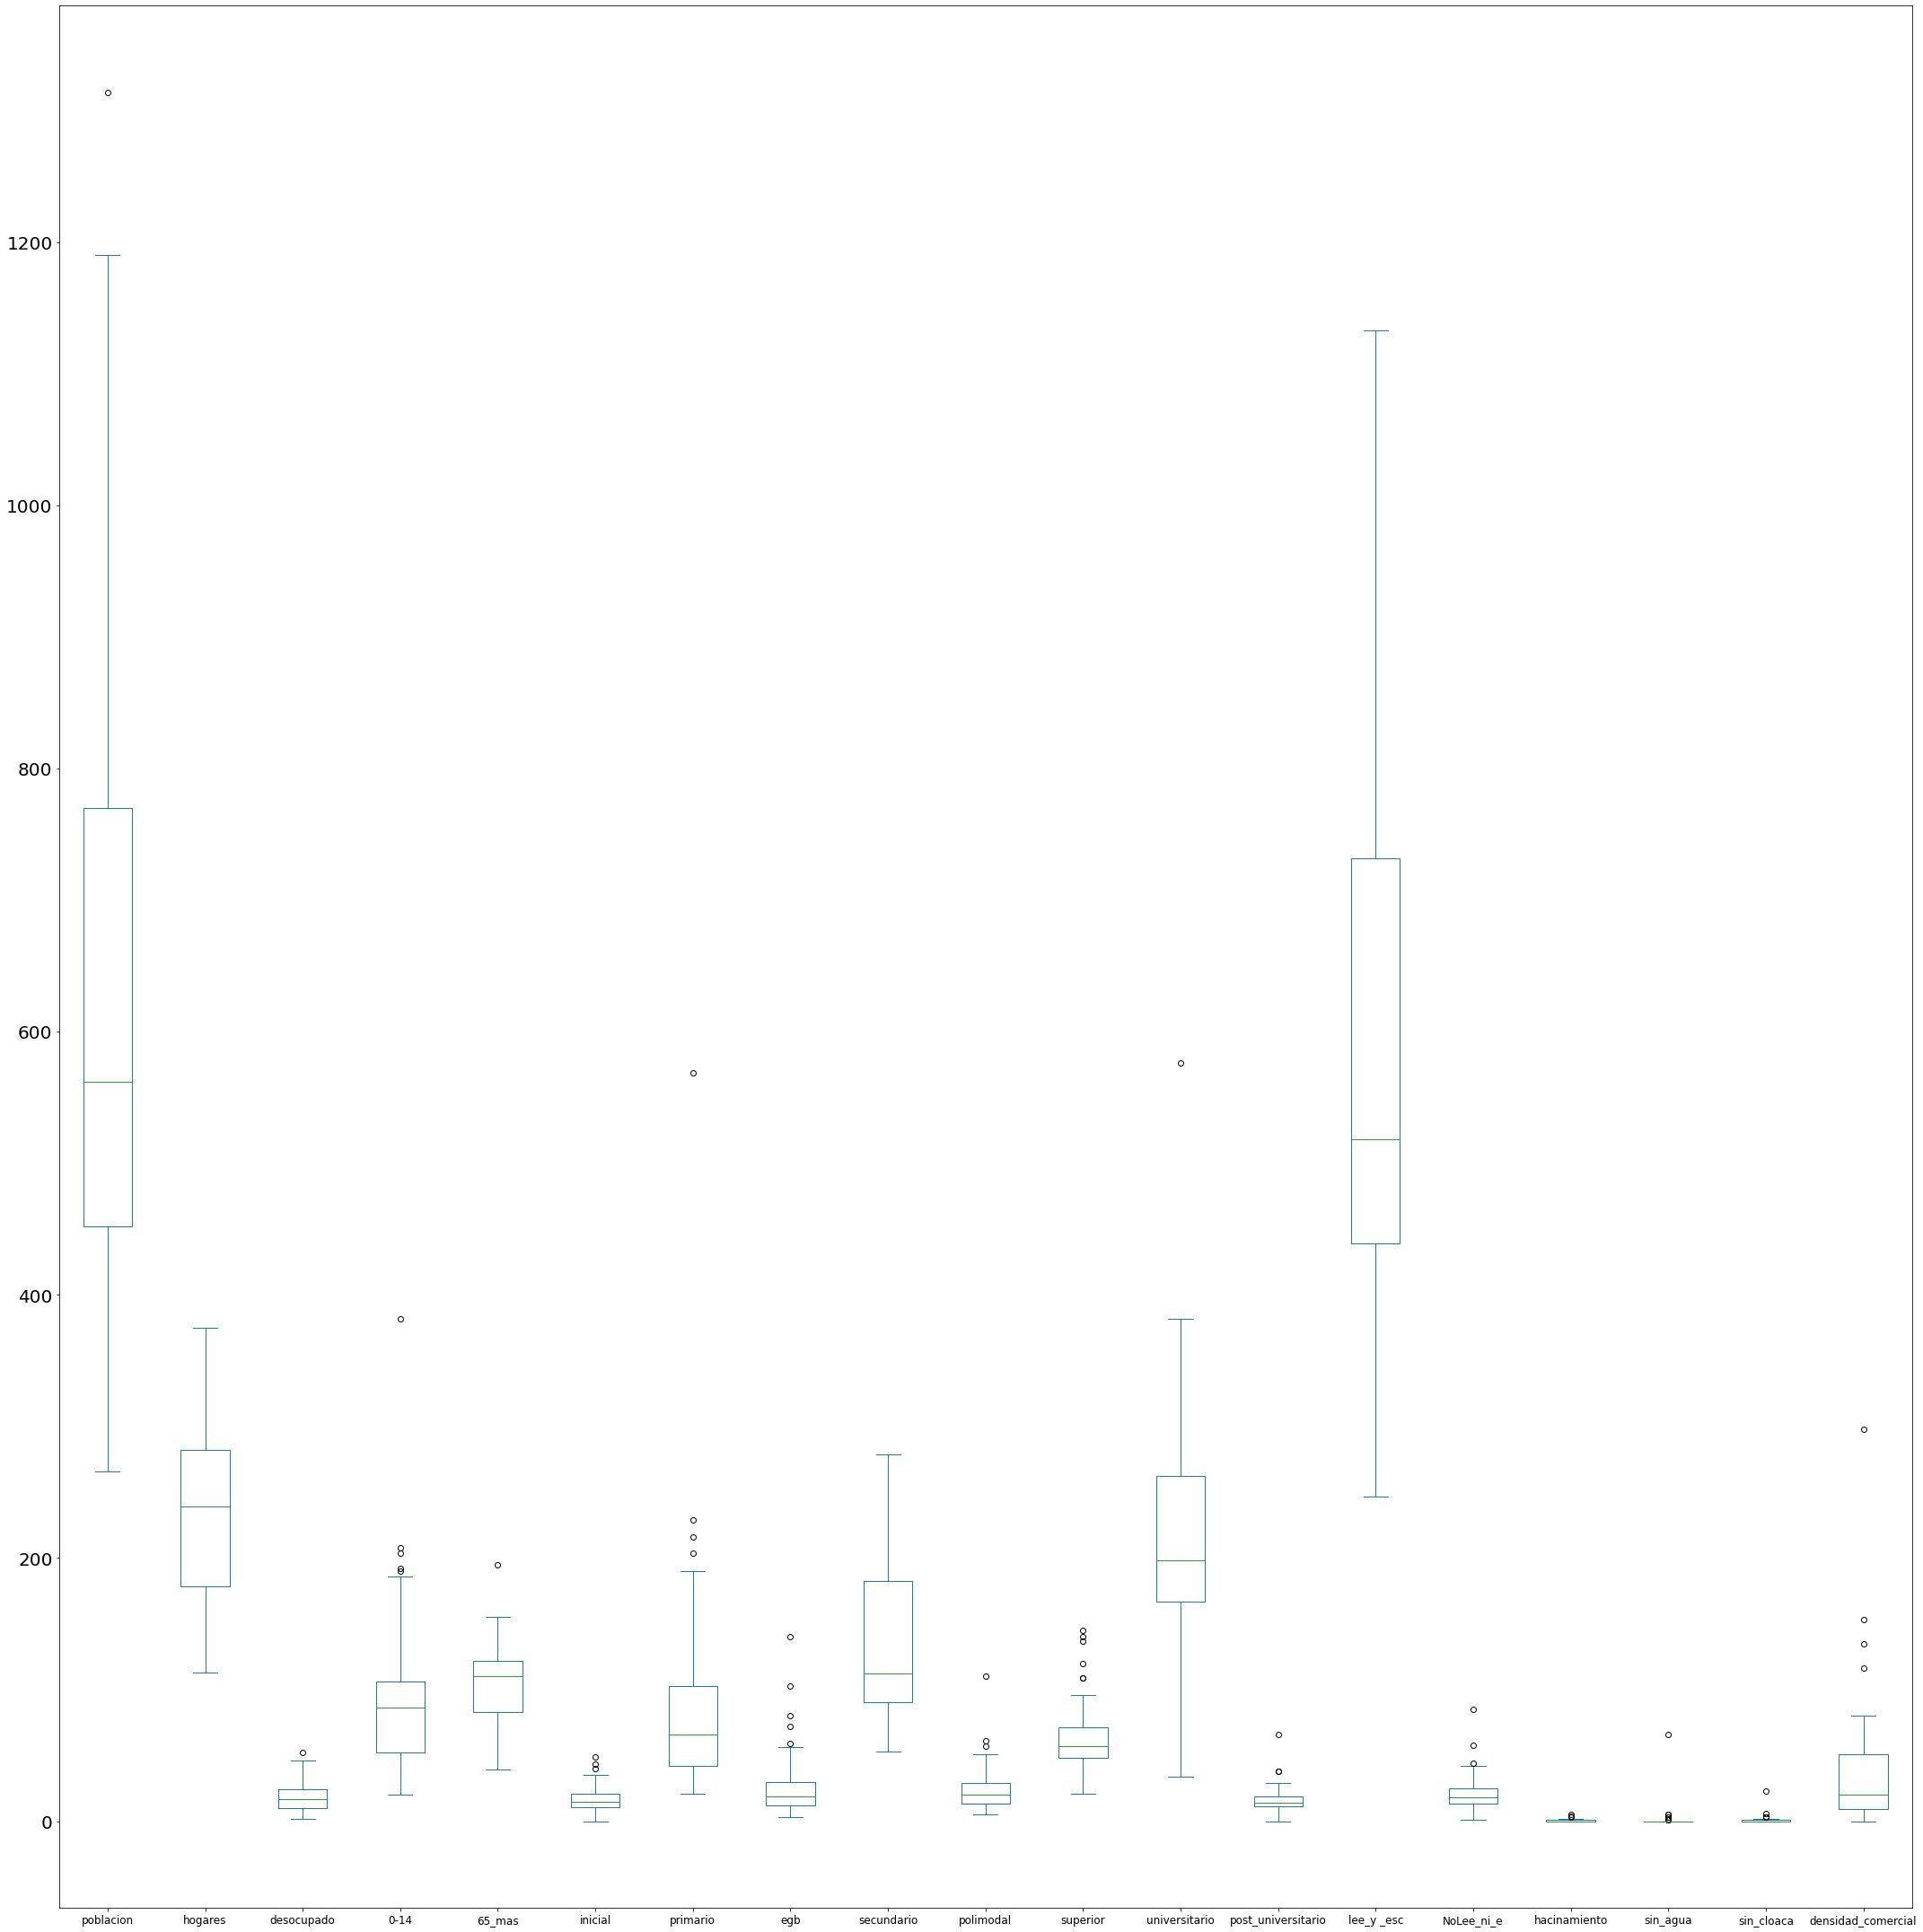

In [133]:
#Visualizacion de outliers

plt.rcParams["figure.figsize"] = [30, 30]
plt.rcParams["figure.autolayout"] = True

ax = PVR_train_test[['poblacion','hogares', 'desocupado', '0-14', '65_mas', 'inicial', 'primario', 'egb', 'secundario', 'polimodal', 'superior', 'universitario', 'post_universitario', 'lee_y _esc', 'NoLee_ni_e',
       'hacinamiento', 'sin_agua', 'sin_cloaca', 'densidad_comercial', ]].plot(kind='box')
plt.xticks(fontsize=12)
plt.yticks(fontsize=20)

plt.show()

In [134]:
outlier= []

def detect_outliers_iqr(data):
    
    data = sorted(data)
    q1= np.percentile(data,25)
    q3= np.percentile(data,75)
        
    IQR= q3-q1
    
    lwr_bound= q1 - (1.5*IQR)
    upr_bound = q3 + (1.5*IQR)
        
    
    for j in data:
        if (j<lwr_bound or j>upr_bound):
            outlier.append(j)
    
    return outlier

In [135]:
detect_outliers_iqr(PVR_train_test['egb'])

[59.0, 72.0, 80.0, 103.0, 140.0]

Ahora invocamos la función y creado el dataset hagamos otra que se quede con los mejores features, splitee los datos y nos guarde el dataset para entrenar.

In [136]:
def Preparando_data (data1):
    
    global x_train, x_test, y_train, y_test
    
    #Aca colocamos la seleccion de los mejores features 
    
    #Separamos el X y el target
    
    X = PVR_train_test[PVR_train_test.columns.difference(['valoracion'])]
    #X = PVR_train_test[['0-14', 'densidad_comercial', 'universitario', 'post_universitario', '65_mas']]
    y = PVR_train_test['valoracion']
    
    #Splieteamos
    x_train, x_test, y_train, y_test = train_test_split(X,y, stratify= y, test_size= 0.3, random_state= 9)
    
    #Estandarizamos los datos (lo dejamos muteado)
    #x_train_std, x_test_std = MinMaxScaler(x_train, x_test)
    
    print('La distribucion de etiquetas es: ', y_train.value_counts() / y_train.value_counts().sum())
    
       

In [137]:
#Generamos los datos para darle de comer al modelo
Preparando_data(PVR_train_test)

La distribucion de etiquetas es:  1.0    0.613636
0.0    0.386364
Name: valoracion, dtype: float64


# Bagging

In [138]:
    classifier = {
        'KNeighbors': KNeighborsClassifier(),
        'LinearSCV': LinearSVC(),
        'SVC': SVC(),
        'SGDC': SGDClassifier(),
        'DecisionTree': DecisionTreeClassifier()
    }
    
    for name, estimator in classifier.items():
        bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(x_train, y_train)
        bag_pred = bag_class.predict(x_test)

        print('Accuracy Bagging with {}:'.format(name), accuracy_score(bag_pred, y_test))
        print('')

Accuracy Bagging with KNeighbors: 0.631578947368421

Accuracy Bagging with LinearSCV: 0.3684210526315789

Accuracy Bagging with SVC: 0.631578947368421

Accuracy Bagging with SGDC: 0.631578947368421

Accuracy Bagging with DecisionTree: 0.5263157894736842



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Boosting

In [139]:
    cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
    
    params = {  
    "n_estimators": [50,100,500],      
    "max_depth": [1,2,3,4],            
    "learning_rate": [0.05,0.075,0.1,0.25,0.5,0.75,1],      
    }
    
    params2 = {  
    "n_estimators": [50,100,500],      
                
    "learning_rate": [0.05,0.075,0.1,0.25,0.5,0.75,1],      
    }
    
    #XG Boost
    
    model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False)
    
    xgb = GridSearchCV(model_xg, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

    xgb.fit(x_train,y_train)
    
    #Gradient Boosting
    
    model_gb = GradientBoostingClassifier()
    
    gb = GridSearchCV(model_gb, param_grid=params, cv=cv, verbose=1, n_jobs=-1)
    
    gb.fit(x_train,y_train)

    
    #Ada Boost 
    
        
    model_adb = AdaBoostClassifier()
    
    adb = GridSearchCV(model_adb, param_grid=params2, cv=cv, verbose=1, n_jobs=-1)
    
    adb.fit(x_train, y_train)   


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75,
                                           1],
                         'n_estimators': [50, 100, 500]},
             verbose=1)

# Mejores parámetros y matrices de confusión

In [145]:
classifiers = [AdaBoostClassifier(learning_rate= 1, n_estimators= 500),
               GradientBoostingClassifier(learning_rate= 0.75, max_depth=1, n_estimators= 100), 
               XGBClassifier(learning_rate= 0.75, max_depth=3, n_estimators= 50)]
for cls in classifiers:
    cls.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

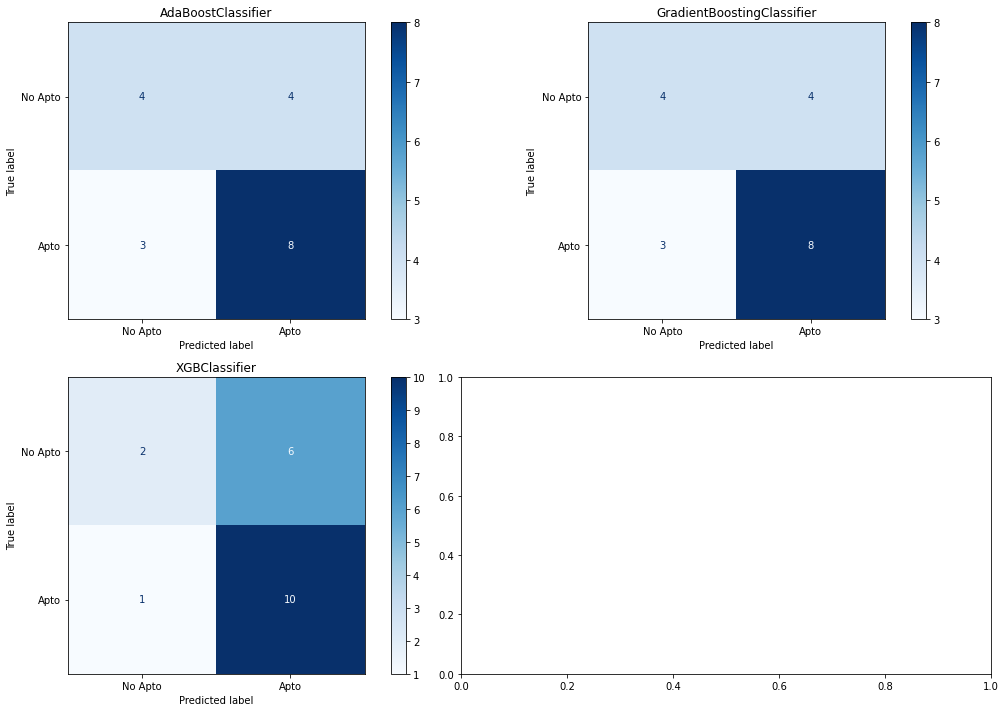

In [146]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          x_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=['No Apto','Apto'])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

# Rendimiento para los modelos con cross validation

In [140]:
def evaluar_rendimiento(modelo, nombre, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

In [141]:
evaluar_rendimiento(xgb.best_estimator_,"XG Boost", x_train, y_train, cv)

Rendimiento de XG Boost:	0.728 ± 0.051


**Mejor rendimiento por el momento**

In [142]:
evaluar_rendimiento(gb.best_estimator_,"Gradient Boosting", x_train, y_train, cv)

Rendimiento de Gradient Boosting:	0.775 ± 0.096


In [143]:
evaluar_rendimiento(abc.best_estimator_,"Ada Boost", x_train, y_train, cv)

Rendimiento de Ada Boost:	0.661 ± 0.154


In [167]:
GradientBoostingClassifier.feature_importances_

# Predicciones para las esquinas

In [152]:
DAM_to_predict

,ID,punto_tipo,poblacion,hogares,desocupado,0-14,65_mas,inicial,primario,egb,...,NoLee_ni_e,hacinamiento,sin_agua,sin_cloaca,densidad_comercial,microzonificacion,macrozonificacion,x,y,index
74,I1,Intersercción,845.0,253.0,36.0,186.0,122.0,27.0,190.0,56.0,...,42.0,2.0,0.0,3.0,8.0,Comercial,Altamente urbano,-68.832689,-32.862203,74
75,I2,Intersercción,958.0,287.0,37.0,207.0,143.0,29.0,174.0,82.0,...,45.0,3.0,0.0,7.0,8.0,NaN,NaN,-68.832652,-32.862198,75
76,I3,Intersercción,845.0,253.0,36.0,186.0,122.0,27.0,190.0,56.0,...,42.0,2.0,0.0,3.0,7.0,Residencial urbano,Urbano,-68.833496,-32.862253,76
77,I4,Intersercción,845.0,253.0,36.0,186.0,122.0,27.0,190.0,56.0,...,42.0,2.0,0.0,3.0,4.0,Residencial urbano,Urbano,-68.834222,-32.862308,77
78,I5,Intersercción,845.0,253.0,36.0,186.0,122.0,27.0,190.0,56.0,...,42.0,2.0,0.0,3.0,3.0,Residencial urbano,Urbano,-68.834852,-32.862354,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,I2382,Intersercción,340.0,146.0,13.0,31.0,66.0,7.0,26.0,8.0,...,8.0,0.0,1.0,3.0,0.0,Especial Parque Gral. San Marti­n,Especial,-68.865545,-32.901277,2455
2456,I2383,Intersercción,5.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,...,2.0,0.0,0.0,0.0,NaN,Especial Parque Gral. San Marti­n,Especial,-68.866127,-32.901451,2456
2457,I2384,Intersercción,5.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,...,2.0,0.0,0.0,0.0,NaN,Especial Parque Gral. San Marti­n,Especial,-68.866127,-32.901451,2457
2458,I2385,Intersercción,5.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,...,2.0,0.0,0.0,0.0,NaN,Especial Parque Gral. San Marti­n,Especial,-68.866127,-32.901451,2458


In [153]:
def predicciones (data, modelo):

  DAM_to_predict.dropna(axis=0, inplace= True)
  DAM_to_predict.drop(['ID', 'index','x','y', 'punto_tipo'], axis=1, inplace= True) 

  #Hacemos las dummies
  pd.get_dummies(DAM_to_predict)

  #Seleccionamos los features establecidos como los mejores
  #DAM_to_predict[[]]

  #Tomamos el mejor modelo

  Predicciones = modelo.predict(DAM_to_predict)

  return(Predicciones)
  print(Predicciones.value_counts())